In [15]:
from xopto.mcml import mc
from xopto.cl import clinfo
from xopto.materials.absorption import oxyhem, deoxyhem
from xopto.materials import skin
from xopto.materials.skin import ReducedScatteringPower

import numpy as np
import matplotlib.pyplot as pp

In [6]:
cl_device = clinfo.gpu()

In [13]:
nphotons = 1e6
wavelengths = np.arange(450e-9, 801e-9, 2e-9)

/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/materials/absorption/base.py:137: UserWarning: Wavelength is out of valid range [100.0, 799.5] nm!
  warnings.warn(


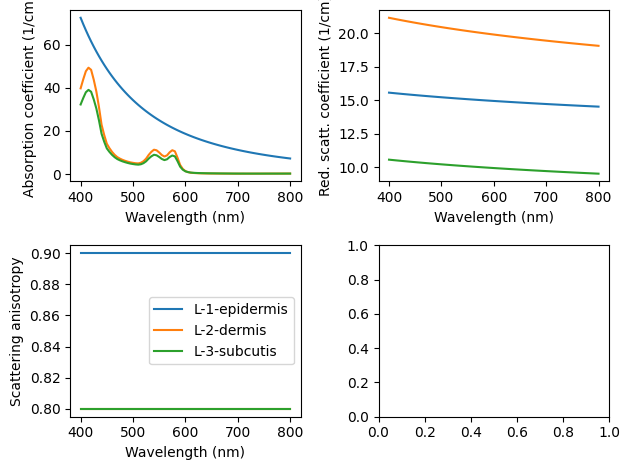

In [ ]:
model_normal = skin.Skin3()
model_normal.plot()

/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/materials/absorption/base.py:137: UserWarning: Wavelength is out of valid range [100.0, 799.5] nm!
  warnings.warn(


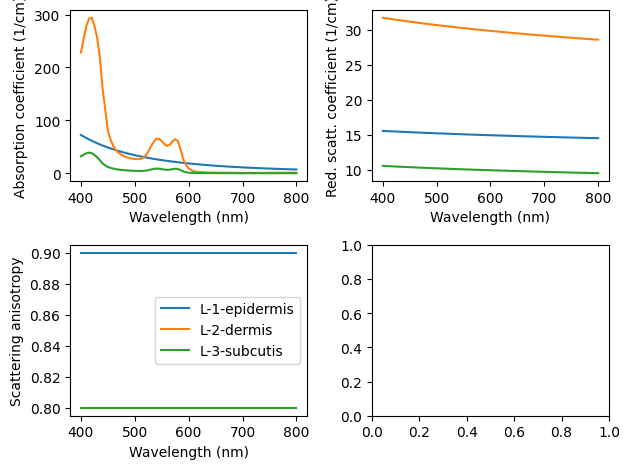

In [27]:
model_hemagioma = skin.Skin3()

dermis = model_hemagioma[1]

dermis.blood = 0.25                    # augment blood volume fraction
dermis.spo2  = 0.80                    # lower oxygen saturation a bit
dermis.musr  = ReducedScatteringPower(30e2, 0.15, 580e-9)  # optional

model_hemagioma.plot()

In [20]:
display(model_normal)
display(model_hemagioma)

Skin3
SkinLayer(d=0.000100, n=water.Daimon(t=293.15), musr=ReducedScatteringPower(a=1500.000000, b=0.100000, wavelength=5.8e-07), g=ConstantValue(0.9) # 128336443112656, baseline_absorption=EpidermisBaselineAbsorption(gamma=0.500000), melanin=0.050000, carotenoid=0.000000, water=0.020000, fat=0.000000, blood=0.000000, spo2=0.970000
SkinLayer(d=0.002000, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=2000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 128336443104352, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.650000, fat=0.000000, blood=0.040000, spo2=0.970000
SkinLayer(d=inf, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=1000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 128336443108432, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.050000, fat=0.400000, blood=0.030000, spo2=0.97

Skin3
SkinLayer(d=0.000100, n=water.Daimon(t=293.15), musr=ReducedScatteringPower(a=1500.000000, b=0.100000, wavelength=5.8e-07), g=ConstantValue(0.9) # 128336230734944, baseline_absorption=EpidermisBaselineAbsorption(gamma=0.500000), melanin=0.050000, carotenoid=0.000000, water=0.020000, fat=0.000000, blood=0.000000, spo2=0.970000
SkinLayer(d=0.002000, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=3000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 128336230739648, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.650000, fat=0.000000, blood=0.250000, spo2=0.800000
SkinLayer(d=inf, n=skin.Ding(t=295.0), musr=ReducedScatteringPower(a=1000.000000, b=0.150000, wavelength=5.8e-07), g=ConstantValue(0.8) # 128336230736432, baseline_absorption=DermisBaselineAbsorption(kwater=1.000000, gamma=0.500000), melanin=0.000000, carotenoid=0.000000, water=0.050000, fat=0.400000, blood=0.030000, spo2=0.97

In [21]:
# DEFINE SOURCE
source = mc.mcsource.Line(
    position=(0.0, 0.0, 0.0),
    direction=(0.0, 0.0, 1.0)
)

# DEFINE A DETECTOR FOR INTEGRATING SPHERE
sp_r = 0.5e-2  # integrating sphere opening in m
detector_top = mc.mcdetector.Radial(
    mc.mcdetector.RadialAxis(
        start=0.0,
        stop=2*sp_r,
        n=2)
)
detectors = mc.mcdetector.Detectors(
    top=detector_top
)

In [25]:
reflectance_spectrum = {
    'normal': np.zeros(len(wavelengths)),
    'hemangioma': np.zeros(len(wavelengths))
}
for i, w in enumerate(wavelengths):
    layers_normal = model_normal.create_mc_layers(w)
    layers_hemangioma = model_hemagioma.create_mc_layers(w)

    # creating a Monte Carlo simulator instance
    mc_obj_normal = mc.Mc(layers_normal, source, detectors, cl_devices=cl_device)
    mc_obj_normal.rmax = 50.0e-3

    mc_obj_hemangioma = mc.Mc(layers_hemangioma, source, detectors, cl_devices=cl_device)
    mc_obj_hemangioma.rmax = 50.0e-3

    # 
    detector = mc_obj_normal.run(nphotons, verbose=True)[-1]
    reflectance_spectrum['normal'][i] = detector.top.reflectance[0] * np.pi * sp_r**2

    detector = mc_obj_hemangioma.run(nphotons, verbose=True)[-1]
    reflectance_spectrum['hemangioma'][i] = detector.top.reflectance[0] * np.pi * sp_r**2

OpenCL source files fused in 9.456610 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 0x645faf86be40>]
OpenCL build options: []
Source code built in 615.414 ms.
OpenCL engine created in 664.053 ms.
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:    681.360 ms
    executed in      :     28.970 ms
    downloaded in    :      1.388 ms
OpenCL source files fused in 8.288590 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 0x645faf86be40>]
OpenCL build options: []
Source code built in 2.084 ms.
OpenCL engine created in 46.056 ms.
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:     56.279 ms
    executed in      :     15.741 ms
    downloaded in    :      1.068 ms
OpenCL source files fused in 8.021652 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' 

/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/materials/absorption/base.py:137: UserWarning: Wavelength is out of valid range [100.0, 799.5] nm!
  warnings.warn(


McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:     50.383 ms
    executed in      :    226.958 ms
    downloaded in    :      0.693 ms
OpenCL source files fused in 7.343139 ms.
Executing OpenCL code on: [<pyopencl.Device 'Intel(R) Iris(R) Xe Graphics' on 'Intel(R) OpenCL Graphics' at 0x645faf86be40>]
OpenCL build options: []
Source code built in 1.996 ms.
OpenCL engine created in 45.080 ms.
McKernel processed 1,000,000 packets in 9,984 threads:
    uploaded/built in:     51.198 ms
    executed in      :    215.157 ms
    downloaded in    :      0.797 ms


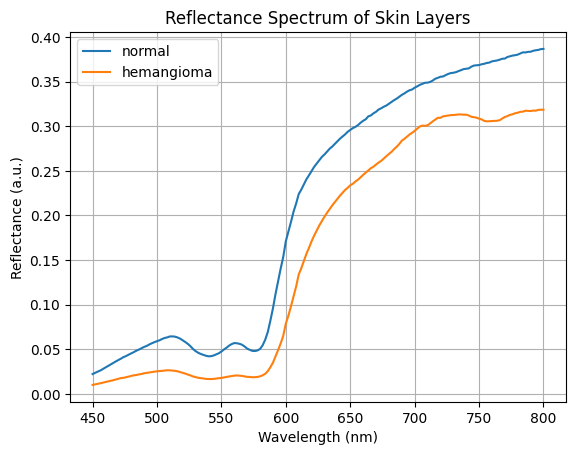

In [26]:
for key, spectrum in reflectance_spectrum.items():
    pp.plot(wavelengths * 1e9, spectrum, label=key)
pp.xlabel('Wavelength (nm)')
pp.ylabel('Reflectance (a.u.)')
pp.title('Reflectance Spectrum of Skin Layers')
pp.legend()
pp.grid()
pp.show()